In [1]:
from featureEng import *
import xgboost
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def get_score(y_true, y_pred):
    if np.sum(y_true**2) == 0:
        return 0
    return 1 - np.sum((y_pred - y_true)**2) / np.sum(y_true**2)

def get_text_from_range(text, y1, y2):
    y1 = int(y1)
    y2 = int(y2)
    y1 = max(1,y1)
    return ' '.join(text.split()[y1:y2])
    
def get_jaccard_score(text, selected_text, y1, y2, sentiment):
    if sentiment == 'neutral' or len(text.split()) < 3:
        return jaccard(text, selected_text)
    return jaccard(get_text_from_range(text, y1, y2),selected_text)

In [2]:
import pandas as pd, numpy as np
import re, string
import operator
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna(' ')
test = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').fillna(' ')
train = featureEng(train)
full_train = train.drop(['textID','text','selected_text','sentiment'],axis=1)
full_train.head()

/home/qiao/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


,num_words,num_unique_words,num_chars,num_stopwords,num_punctions,num_words_upper,num_words_title,mean_word_len,num_top,num_least,...,svd_charcv_290,svd_charcv_291,svd_charcv_292,svd_charcv_293,svd_charcv_294,svd_charcv_295,svd_charcv_296,svd_charcv_297,svd_charcv_298,svd_charcv_299
0,7,7,36,4,2,1,1,4.142857,5,0,...,-0.181307,-0.048795,0.045572,-0.152438,0.352329,0.010068,-0.310753,-0.075992,-0.280114,-0.143599
1,10,10,46,5,3,2,4,3.600000,7,0,...,0.370379,0.226588,-0.106820,0.070859,-0.113983,0.042331,-0.298930,-0.126348,-0.266225,-0.326065
2,5,5,25,2,3,0,0,4.200000,2,1,...,-0.330550,0.068733,-0.096464,-0.116629,-0.015671,0.201392,-0.150381,0.142914,-0.043850,0.074250
3,5,5,31,2,1,0,0,5.200000,2,0,...,0.128487,0.117137,-0.221083,0.003785,0.428028,0.052413,-0.022876,0.319257,0.003706,-0.270019
4,14,14,75,7,6,0,1,4.357143,8,0,...,-0.389752,0.236706,0.576617,0.059367,-0.312608,0.321487,-0.100574,-0.195989,0.090826,-0.373494


In [3]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.2, eta = 0.2, gamma = 0):
    param = {}
    param['objective'] = 'reg:squarederror'
    param['max_depth'] = 6
    #param['silent'] = True
    param['eval_metric'] = "rmse"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    param['learning_rate'] = eta
    param['n_estimators'] = 1000
    param['gamma'] = gamma
    param['nthread'] = 4
    param['scale_pos_weight'] = 1
    param['tree_method'] = 'gpu_hist'
    param['gpu_id'] = 0
    param['verbosity'] = 1
    param['reg_lambda'] = 3e-5
    
    model = xgb.XGBRegressor(**param)
    model.fit(train_X,train_y)
    pred_test_y = model.predict(test_X)
    pred_test_y2 = None
    if test_X2 is not None:
        pred_test_y2 = model.predict(test_X2)
    return pred_test_y, pred_test_y2, model

In [11]:
###XGBoost model:
#nfold = 5
#tscv = TimeSeriesSplit(n_splits=nfold)
def training(train, target='y1'):
    data_X = train.drop(['y1','y2'],axis=1)
    if target == 'y1': # use first step y2 info
        model_y2 = xgb.XGBRegressor()
        model_y2.load_model("xgb_model_y2.model")
        data_X['y2'] = model_y2.predict(data_X)
    data_y = train[target]
    #skf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2019)
    #valid_scores = []
    #train_scores = []
    #ifold = 0
    total_samples = len(train)
    idx_split = int(total_samples*0.8)
    train_X, valid_X = data_X.iloc[:idx_split], data_X.iloc[idx_split:]
    train_y, valid_y = data_y.iloc[:idx_split], data_y.iloc[idx_split:]
    pred_valid_y, pred_train_y, model = runXGB(train_X, train_y, valid_X, valid_y, test_X2=train_X,
                                               seed_val=0, colsample=0.85,eta=0.01, gamma=0)
    print('train-sq:',np.mean(train_y**2),'\t valid-sq:',np.mean(valid_y**2))
    train_score = get_score(train_y, pred_train_y)
    valid_score = get_score(valid_y, pred_valid_y)
    #valid_acc_score = get_accuracy(valid_y, pred_valid_y)
    print("XGB on train r2 scores : ", train_score)
    print("XGB on valid r2 scores : ", valid_score)
    #print("XGB on valid acc scores : ", valid_acc_score)
    model.save_model(f'xgb_model_{target}.model')
    
def pred_test(test):
    model_y1 = xgb.XGBRegressor()
    model_y2 = xgb.XGBRegressor()
    model_y1.load_model("xgb_model_y1.model")
    model_y2.load_model("xgb_model_y2.model")
    test = featureEng(test,training=False)
    df_test = test.drop(['textID','text','sentiment'],axis=1,errors='ignore')
    y2 = model_y2.predict(df_test)
    xgb.plot_importance(model_y1,max_num_features=30)
    xgb.plot_importance(model_y2,max_num_features=30)
    df_test['y2'] = y2
    y1 = model_y1.predict(df_test)
    test['selected_text'] = test['text']
    for i in test.index:
        text = test.loc[i, 'text']
        test.loc[i, 'selected_text'] = get_text_from_range(text, y1[i], y2[i])
    return test[['textID','selected_text']]
                                                
def validation(full_train, idx_split):
    model_y1 = xgb.XGBRegressor()
    model_y2 = xgb.XGBRegressor()
    model_y1.load_model("xgb_model_y1.model")
    model_y2.load_model("xgb_model_y2.model")
    df_full_train = full_train.drop(['textID','text','selected_text','sentiment','y1','y2'],axis=1,errors='ignore')
    y2 = model_y2.predict(df_full_train)
    df_full_train['y2'] = y2
    y1 = model_y1.predict(df_full_train)
    train, valid = full_train.iloc[:idx_split], full_train.iloc[idx_split:]
    train_jac = []
    valid_jac = []
    for i in train.index:
        train_jac.append(get_jaccard_score(train.loc[i, 'text'], 
                                           train.loc[i, 'selected_text'], 
                                           y1[i], y2[i], 
                                           train.loc[i, 'sentiment']))
    for i in valid.index:
        valid_jac.append(get_jaccard_score(valid.loc[i, 'text'], 
                                           valid.loc[i, 'selected_text'],
                                           y1[i], y2[i], 
                                           valid.loc[i, 'sentiment']))
    print("XGB on train jac scores : ", np.mean(train_jac))
    print("XGB on valid jac scores : ", np.mean(valid_jac))

In [5]:
training(full_train,'y2')
training(full_train,'y1')

train-sq: 171.0514465065502 	 valid-sq: 170.83372748772058
XGB on train r2 scores :  0.9588383108884134
XGB on valid r2 scores :  0.9101090903811208
train-sq: 34.52620087336245 	 valid-sq: 33.72130252865199
XGB on train r2 scores :  0.8917993618031018
XGB on valid r2 scores :  0.5531544394582543


In [6]:
validation(train, int(len(train)*0.8))

XGB on train jac scores :  0.5622783847888382
XGB on valid jac scores :  0.5250927640222923


,textID,selected_text
0,f87dea47db,session of the day http://twitpic.com/67ezh
1,96d74cb729,really exciting (precisely -- skyscrapers galo...
2,eee518ae67,she has to quit her
3,01082688c6,bday!
4,33987a8ee5,- I like
...,...,...
3529,e5f0e6ef4b,im very tired but i can`t
3530,416863ce47,net which keeps me alive
3531,6332da480c,know what you mean. My little dog is sinking
3532,df1baec676,your next youtube video gonna be


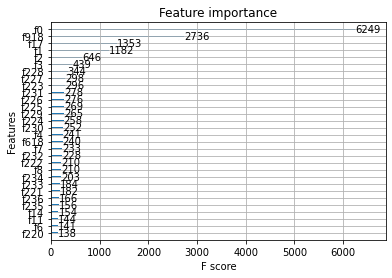

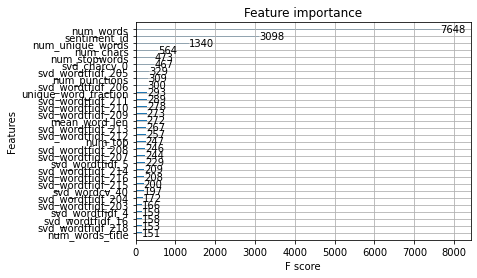

In [12]:
pred_test(test)